In [1]:
import sys
# assume using virtual env at project root
sys.path.append('../../venv/lib/python3.6/site-packages/')

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# from collections import Counter

from pathlib import Path
from urllib.parse import urlparse

In [4]:
import emoji

In [5]:
from nltk.corpus import stopwords
# from nltk.tokenize.casual import TweetTokenizer

# symlinked (might not work in Windows)
from TweetNLP import CMUTweetTagger as POStagger

# import requests

---
# SLO Data Analysis
**RT excluded version**

Shuntaro Yada  
Mar 2018

In order to consider which features to apply to our stance detection model, the *shape* of SLO data is analysed.
This report investigates the following points for each company.

## Tweet Properties

Metadata of tweets

1. Time series
2. Users

## Linguistic Characteristics

1. Distributions of the character count of tweets
2. Distributions of the word count of tweets
3. Distributions of the unique-word count of tweets
4. Distributions of the hashtag count of tweets
5. Distributions of the mention count of tweets
6. Distributions of the Stock symbol count of tweets
7. Distributions of the URL count of tweets
8. Emojis of tweets
9. Word Frequency
    - Total words
    - Total vocabularies
    - Hapax legomena
    - POS tag distributions
    - Content words
    - Function words
    - Twitter specific tags (redundant to items 4-7 above)
    - Out-of-Vocabulary words



---
## Load the data

In [9]:
tmc = Path('./slo-tweets-20160101-20180304/')
df = pd.DataFrame()
for fp in tmc.iterdir():
#     names = fp.name.split('_')
    if fp.name.endswith('.json'):
        print(fp.name)
        df_ = pd.read_json(fp)
#         df_['company'] = names[0]
        df_['company'] = fp.stem
        df = df.append(df_, ignore_index=True)

adani.json
bhp.json
cuesta.json
fortescue.json
ilukaresources.json
newmontmining.json
oilsearch.json
riotinto.json
santos.json
whitehavencoal.json
woodside.json


In [10]:
df = df.query('retweet_flag != "Y"')  # YC tweets (QT) have original some contents
gb_com = df.groupby('company')
gb_com.size()

company
adani             107703
bhp                22297
cuesta               303
fortescue           4257
ilukaresources      1267
newmontmining        294
oilsearch            750
riotinto           10060
santos             15518
whitehavencoal      2141
woodside            5101
dtype: int64

In [114]:
df.columns

Index(['created_at_utc', 'hashtags', 'id', 'in_reply_to_status_id',
       'original_tweet_id', 'retweet_flag', 'screen_name', 'to_user',
       'to_user_id', 'to_user_name', 'tweet', 'user_id', 'user_mentions',
       'company'],
      dtype='object')

In [8]:
df.sample(5)

,created_at_utc,hashtags,id,in_reply_to_status_id,original_tweet_id,retweet_flag,screen_name,to_user,to_user_id,to_user_name,tweet,user_id,user_mentions,company
330076,2017-11-11T09:46:38Z,[Adani],929118125873807360,NaN,NaN,N,JohnLocker4,QLDLNP,272394558.0,NaN,@QLDLNP @QLDlabor support #Adani &amp; the des...,1306197774,"[QLDLNP, QLDLabor]",adani
305033,2017-10-26T10:38:14Z,None,923332906713366528,NaN,NaN,N,della79,nytimes,807095.0,NaN,@nytimes on Adani; The last thing Australia an...,23841561,[nytimes],adani
296256,2017-10-16T13:13:37Z,"[adani, coal]",919748132715372544,NaN,NaN,N,junglefruits,None,NaN,NaN,#adani #coal\nThe environmental annihilation t...,57871450,[independentaus],adani
488479,2016-05-24T09:32:24Z,"[LNG, energy, gas]",734889749794721792,NaN,NaN,N,angelamacd,None,NaN,NaN,InterOil's former CEO Phil Mulacek to fight Oi...,49520993,None,oilsearch
528600,2016-06-19T17:18:03Z,[nowplaying],744429019588767744,NaN,NaN,N,LightFMNOW,None,NaN,NaN,Now playing: Topic / Nico Santos - Home #nowpl...,164067322,None,santos


## Tweet Properties

### Time series

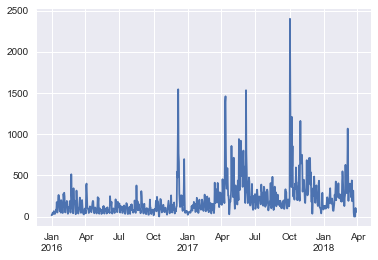

In [43]:
pd.to_datetime(df['created_at_utc']).value_counts().resample('1D').sum().plot()

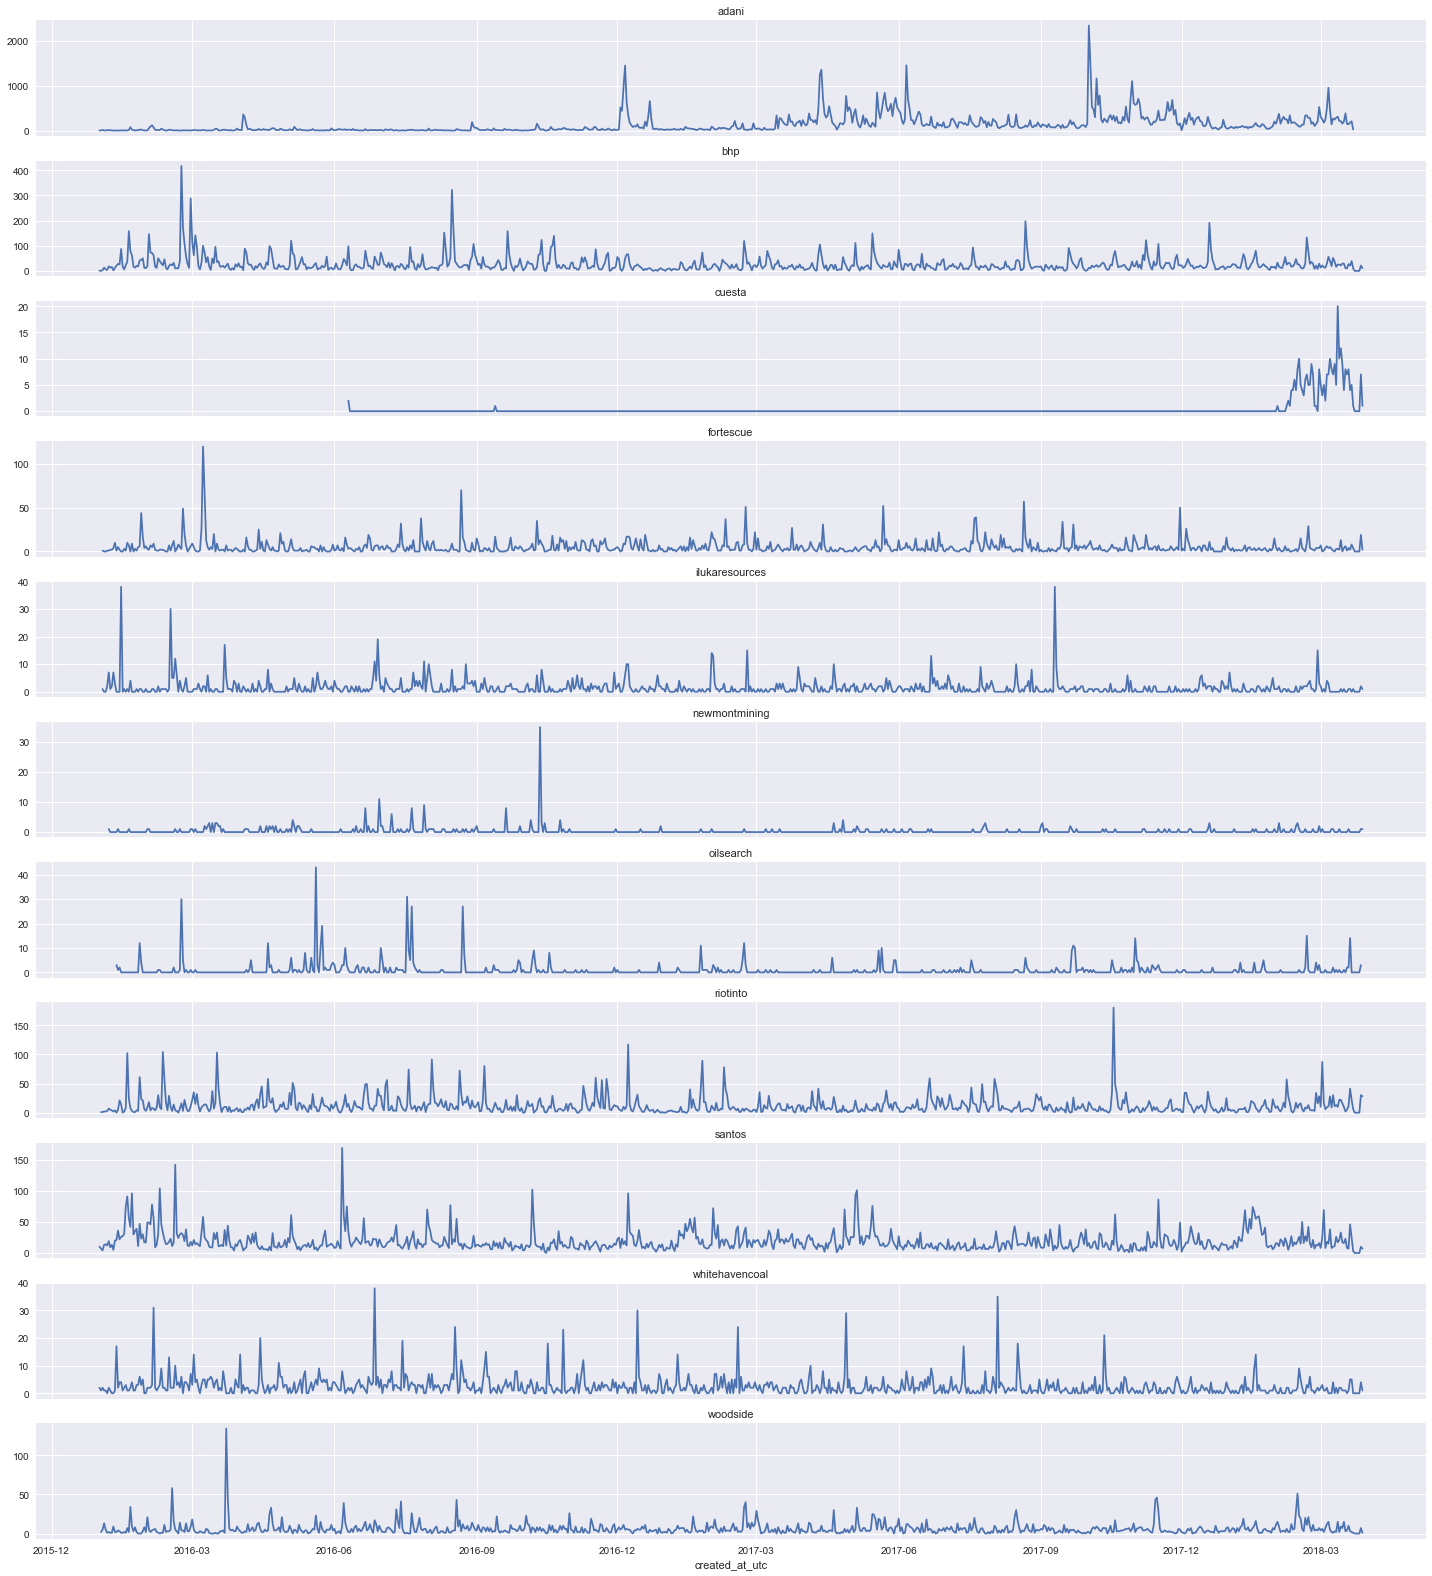

In [53]:
def ts_plot(col, **kwargs):
    ax = plt.gca()
    data = kwargs.pop('data')
    ts = pd.to_datetime(data[col]).value_counts().resample('1D').sum()
    ax.plot(ts)

grid = sns.FacetGrid(df[['created_at_utc', 'company']], row='company', size=2, aspect=10, sharey=False)
grid.map_dataframe(ts_plot, 'created_at_utc').set_titles('{row_name}')

In [12]:
def bar_plot(col, **kwargs):
    ax = plt.gca()
    data = kwargs.pop('data')
    height = data[col].value_counts(normalize=True)
    height.sort_index(inplace=True)
    ax.bar(height.index, height)

In [10]:
def bar_plot_zipf(col, **kwargs):
    ax = plt.gca()
    data = kwargs.pop('data')
    height = data[col].value_counts().value_counts(normalize=True)
    ax.bar(height.index, height)

### Users

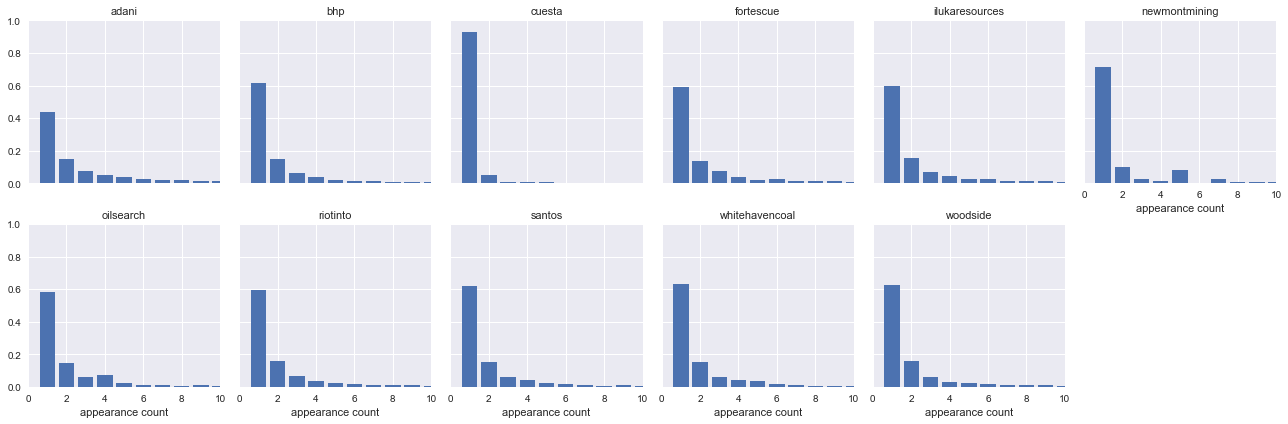

In [11]:
grid = sns.FacetGrid(df[['user_id', 'company']], col='company', col_wrap=6, ylim=(0, 1), xlim=(0, 10))
grid.map_dataframe(bar_plot_zipf, 'user_id').set_titles('{col_name}').set_xlabels('appearance count')

most users appear only once

In [55]:
df[['company', 'screen_name']].groupby('company')\
    .apply(lambda x: x['screen_name'].value_counts(normalize=True).head())#.value_counts(normalize=True)\
                                           #.sort_index(ascending=False).head())

company                        
adani           JohnLocker4        0.019345
                overthelies2010    0.013138
                takvera            0.012822
                DrCnfzd            0.009450
                WgarNews           0.008753
bhp             CommSec            0.046836
                aus_business       0.030263
                FinancialReview    0.019950
                Bell_Potter        0.018960
                3novicesSydney     0.017248
cuesta          Marana_tha         0.052045
                LeagueUnlimited    0.018587
                arimefrance        0.014870
                DD_Serena_         0.011152
                Natyma99           0.011152
fortescue       aus_business       0.033286
                FortescueNews      0.029745
                FinancialReview    0.022899
                CommSec            0.018178
                3novicesSydney     0.017941
ilukaresources  BayplayTours       0.039777
                ilubphotography    0.038186


the most frequent user's tweets constitute more than 1% of each company's data

----

## Linguistic Characteristics

### Character counts

In [13]:
def relhist_proc(col, **kwargs):
    ax = plt.gca()
    data = kwargs.pop('data')
    proc = kwargs.pop('proc')
    processed = proc(data[col])
    # relative frequency histgram
    # https://stackoverflow.com/questions/9767241/setting-a-relative-frequency-in-a-matplotlib-histogram
    ax.hist(processed, weights=np.ones_like(processed) / processed.size , **kwargs)

In [14]:
def char_len(tweets):
    return tweets.str.len()

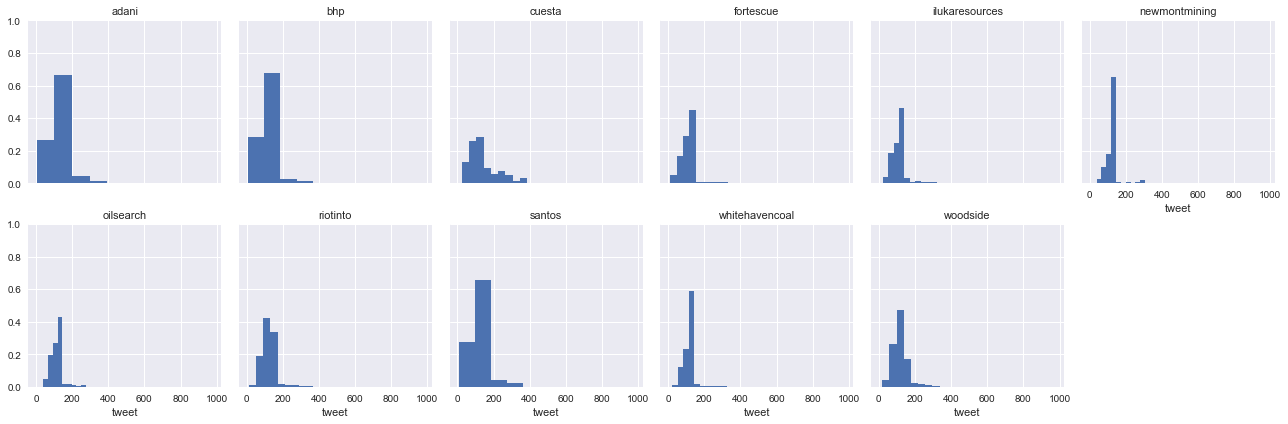

In [16]:
grid = sns.FacetGrid(df[['tweet', 'company']], col='company', col_wrap=6, ylim=(0, 1))
grid.map_dataframe(relhist_proc, 'tweet', bins=10, proc=char_len).set_titles('{col_name}')

- relatively long
- a bit shorter from RT-included data

### Word counts (word token)

In [17]:
pos_tweets = POStagger.runtagger_parse(df['tweet'].str.replace(r"[\t\n\r]", ' ').str.replace(r"^RT @[a-zA-Z_0-9]+: ", ''))

In [70]:
df_tokens = pd.concat([df.company.reset_index(), pd.Series(pos_tweets, name='tokens')], axis=1).drop('index', axis=1)
df_tokens.head()

,company,tokens
0,adani,"[(@CFMEUWA, @, 0.9983), (@01507db5dba34b2, @, ..."
1,adani,"[(Adani's, Z, 0.6777), (Carmichael, ^, 0.9944)..."
2,adani,"[("", ,, 0.9893), (We're, L, 0.9092), (swimming..."
3,adani,"[(“, ,, 0.9717), (A, D, 0.9735), (Power, N, 0...."
4,adani,"[(Adani, ^, 0.5745), (Carmichael, ^, 0.9996), ..."


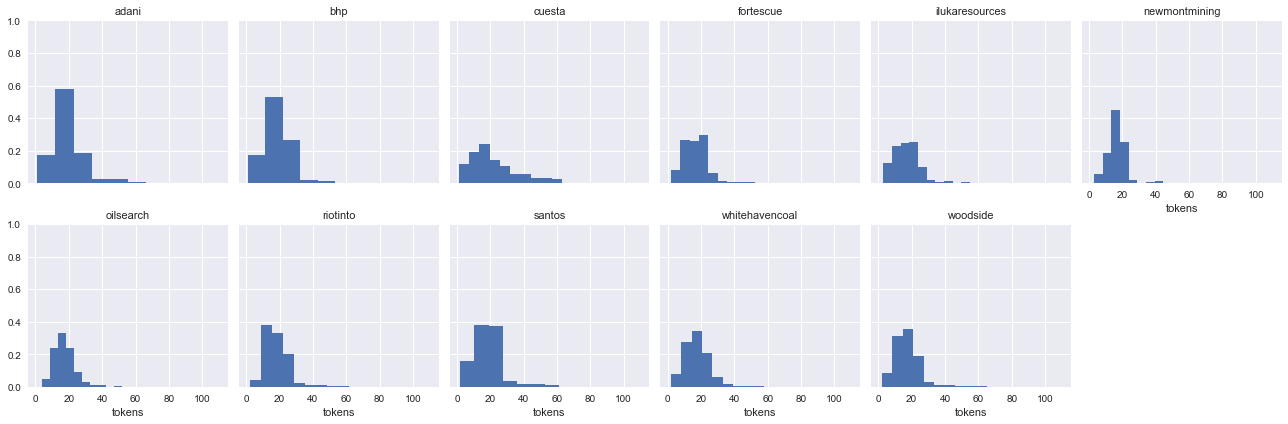

In [40]:
# run after CMUTweetTagger applied
grid = sns.FacetGrid(df_tokens[['tokens', 'company']], col='company', col_wrap=6, ylim=(0, 1))
grid.map_dataframe(relhist_proc, 'tokens', proc=lambda x: x.apply(len)).set_titles('{col_name}')

- word-wise, not so long?
- the proportion of shorter tweets increases against RT-included data

### Unique word counts (word type)

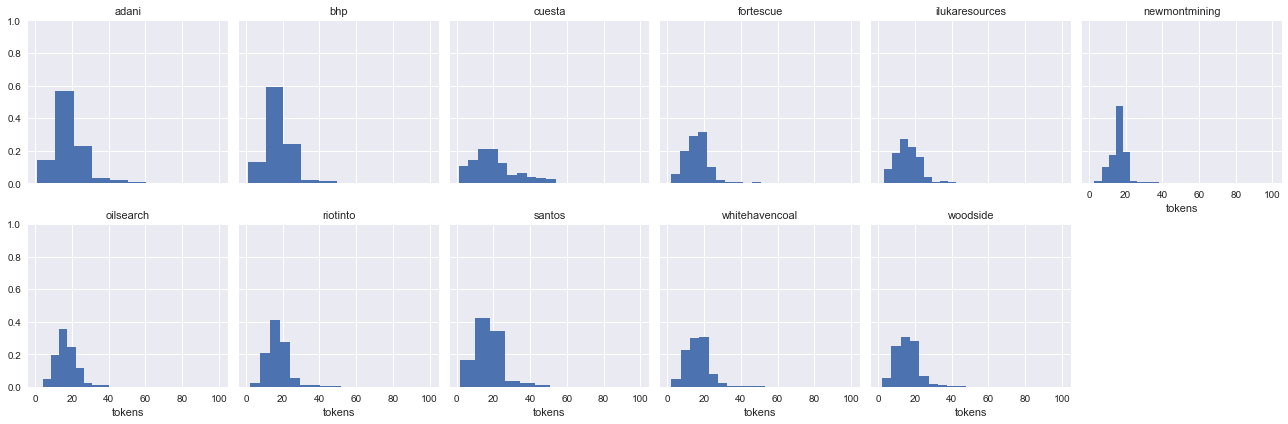

In [41]:
# run after CMUTweetTagger applied
grid = sns.FacetGrid(df_tokens[['tokens', 'company']], col='company', col_wrap=6, ylim=(0, 1))
grid.map_dataframe(relhist_proc, 'tokens', proc=lambda x: x.apply(lambda y: len(set([t for t, p, _ in y])))).set_titles('{col_name}')

similar to word counts

#### Word redundancy

For each tweet, word type counts are subtracted from word token counts, which produces redundant words

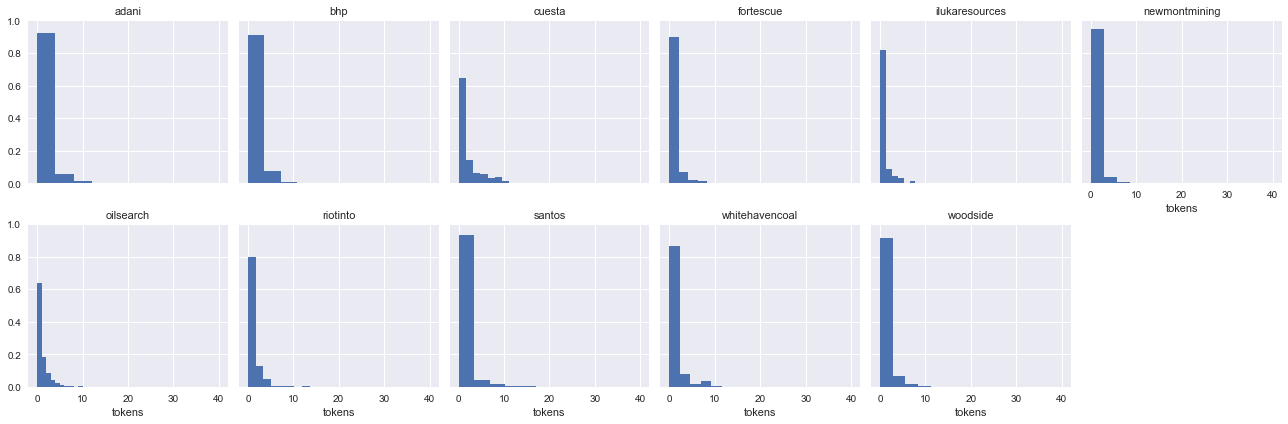

In [42]:
# run after CMUTweetTagger applied
grid = sns.FacetGrid(df_tokens[['tokens', 'company']], col='company', col_wrap=6, ylim=(0, 1))
grid.map_dataframe(relhist_proc, 'tokens', proc=lambda x: x.apply(len) - x.apply(lambda y: len(set([t for t, p, _ in y])))).set_titles('{col_name}')

most tweets has no redundant words; most tweets are composed of unique words

### Hashtags

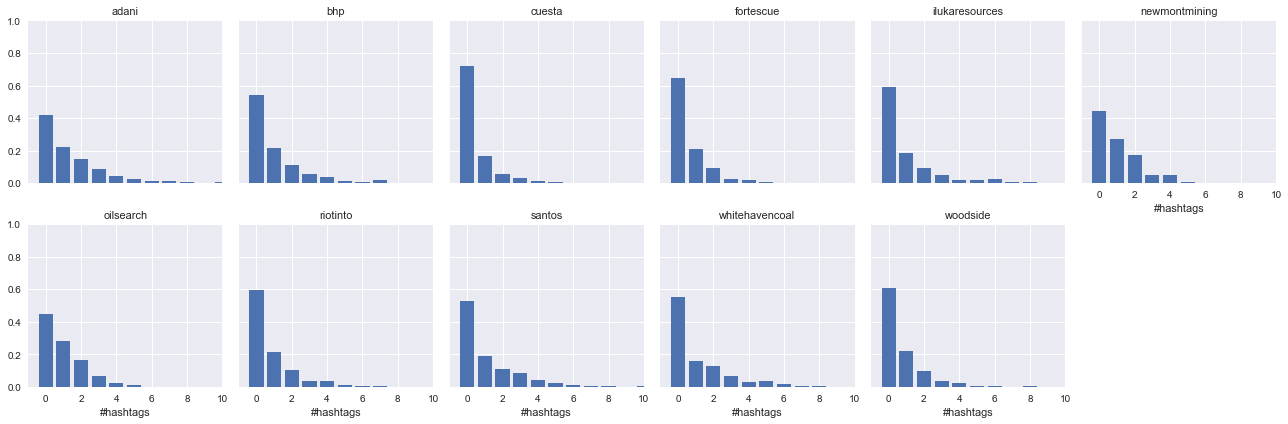

In [13]:
df['#hashtags'] = df['hashtags'].apply(lambda x: len(x) if x is not None else 0)
# companies = df['company']

grid = sns.FacetGrid(df[['#hashtags', 'company']], col='company', col_wrap=6, ylim=(0, 1), xlim=(-1, 10))
grid.map_dataframe(bar_plot, '#hashtags').set_titles('{col_name}')

many tweets have some hashtags

In [14]:
# top hashtags
df[['company', 'hashtags']].groupby('company')\
    .apply(lambda x: pd.Series([hashtag 
                                for hashtags in x['hashtags'] if hashtags is not None 
                                for hashtag in hashtags])\
                               .value_counts(normalize=True)\
                               .head())

company                        
adani           StopAdani          0.142206
                auspol             0.126790
                Adani              0.115037
                adani              0.043532
                qldpol             0.039665
bhp             ausbiz             0.089920
                BHP                0.083087
                auspol             0.033383
                ASX                0.029378
                markets            0.025810
cuesta          auspol             0.038710
                IWD2018            0.025806
                IntrustSuperCup    0.012903
                7News              0.012903
                Australia          0.012903
fortescue       ausbiz             0.113698
                Fortescue          0.040745
                auspol             0.032208
                ironore            0.030656
                3Novices           0.029492
ilukaresources  Iluka              0.058537
                ausbiz             0.035772


In [19]:
# top hashtags, lower-cased
df[['company', 'hashtags']].groupby('company')\
    .apply(lambda x: pd.Series([hashtag.lower() 
                                for hashtags in x['hashtags'] if hashtags is not None 
                                for hashtag in hashtags])\
                               .value_counts(normalize=True)\
                               .head(5))

company                        
adani           stopadani          0.173204
                adani              0.160535
                auspol             0.137473
                qldpol             0.044905
                coal               0.032792
bhp             ausbiz             0.093489
                bhp                0.090442
                auspol             0.035864
                asx                0.034297
                markets            0.026462
cuesta          auspol             0.038710
                iwd2018            0.025806
                intrustsupercup    0.012903
                7news              0.012903
                australia          0.012903
fortescue       ausbiz             0.118743
                auspol             0.048118
                fortescue          0.046566
                ironore            0.034924
                3novices           0.029492
ilukaresources  iluka              0.082114
                ausbiz             0.042276


### Mentions

In [124]:
df['user_mentions'].count() / len(df)

0.45361251344864684

In [128]:
df['in_reply_to_status_id'].count() / len(df)

0.20088435937149005

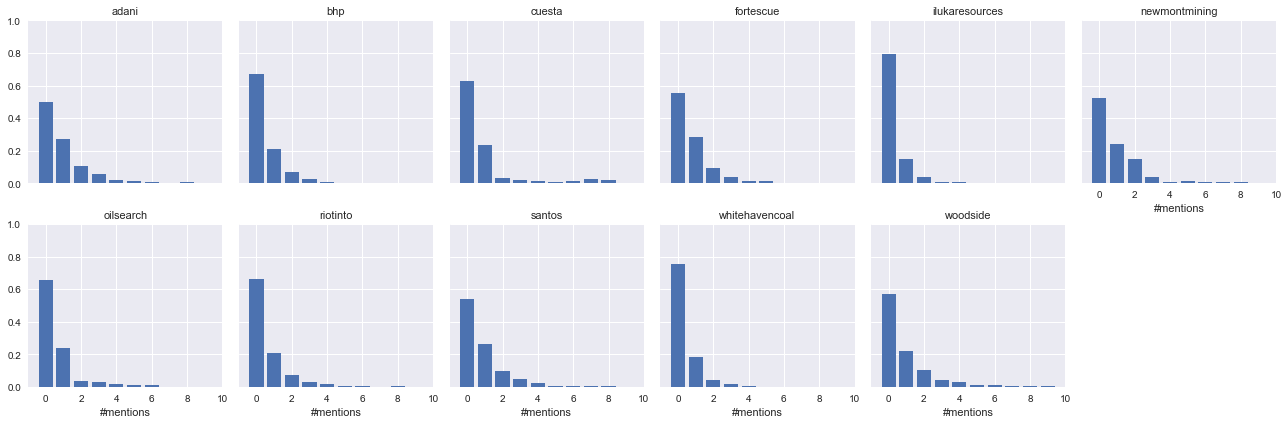

In [57]:
# the number of mentions within tweets
df['#mentions'] = df['user_mentions'].apply(lambda x: len(x) if isinstance(x, list) else 0)

grid = sns.FacetGrid(df[['#mentions', 'company']], col='company', col_wrap=6, ylim=(0, 1), xlim=(-1, 10))
grid.map_dataframe(bar_plot, '#mentions').set_titles('{col_name}')

there are even substantial multi-mention tweets.

In [119]:
# top mentions
df[['company', 'user_mentions']].groupby('company')\
    .apply(lambda x: pd.Series([mention 
                                for mentions in x['user_mentions'] if mentions is not None 
                                for mention in mentions])\
                               .value_counts(normalize=True)\
                               .head())

company                        
adani           AnnastaciaMP       0.049434
                stopadani          0.038231
                billshortenmp      0.028138
                TurnbullMalcolm    0.027372
                abcnews            0.021522
bhp             bhpbilliton        0.117490
                bhp                0.114142
                abcnews            0.030293
                FinancialReview    0.028787
                smh                0.020753
cuesta          cqc2t_             0.101626
                BoltzmannMick      0.060976
                thepmo             0.056911
                Science_Academy    0.056911
                transhumanismAU    0.056911
fortescue       fortescue          0.254232
                FortescueNews      0.193868
                FinancialReview    0.019483
                smh                0.015011
                TurnbullMalcolm    0.011498
ilukaresources  IlukaResources     0.252747
                ilukamusic         0.038462


stance-fixed users such as `@stopadani` might contribute

### Stock symbols

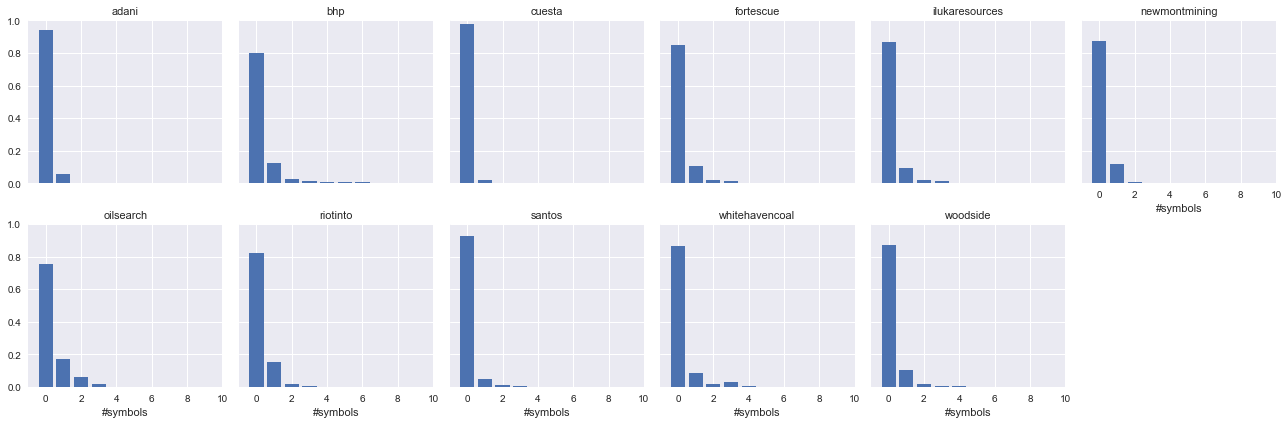

In [58]:
df['#symbols'] = df.tweet.str.findall(r"\$\w+").apply(len)

grid = sns.FacetGrid(df[['#symbols', 'company']], col='company', col_wrap=6, ylim=(0, 1), xlim=(-1, 10))
grid.map_dataframe(bar_plot, '#symbols').set_titles('{col_name}')

In [132]:
(df['#symbols'] > 0).sum() / len(df)

0.09305281327957815

companies are sometimes mentioned by stock symbols

### URLs

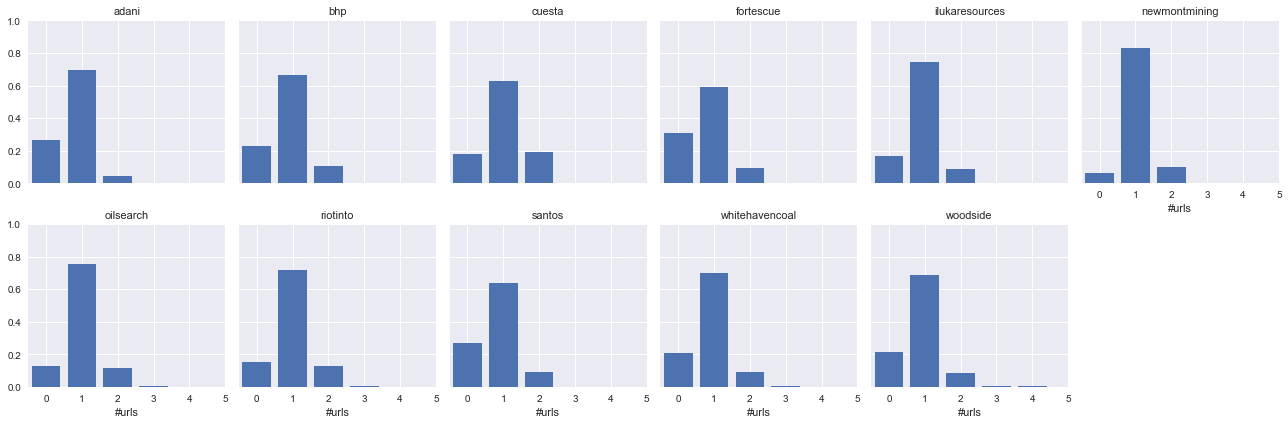

In [59]:
import re
ptn_url = re.compile(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")
df['#urls'] = df.tweet.str.findall(ptn_url).apply(len)

grid = sns.FacetGrid(df[['#urls', 'company']], col='company', col_wrap=6, ylim=(0, 1), xlim=(-0.5, 5))
grid.map_dataframe(bar_plot, '#urls').set_titles('{col_name}')

In [133]:
(df['#urls'] > 0).sum() / len(df)

0.7501566545678108

over a half of tweets have URLs.
According to one company analysis, most of them are very likely to be news articles

### Emojis

In [61]:
ptn_emoji = emoji.get_emoji_regexp()
df['emojis'] = df.tweet.str.extractall(ptn_emoji).groupby(level=0).apply(lambda x: x.values.flatten())

In [129]:
df['emojis'].count() / len(df)

0.027186956881569146

In [63]:
df['#emojis'] = df['emojis'].apply(lambda x: len(x) if x is not np.nan else 0)

In [64]:
# emoji-bearing tweets
df[['company', '#emojis']].groupby('company').apply(lambda x: 1 - x['#emojis'].value_counts(normalize=True).loc[0])

company
adani             0.027680
bhp               0.017158
cuesta            0.055762
fortescue         0.022427
ilukaresources    0.041368
newmontmining     0.013605
oilsearch         0.012032
riotinto          0.010846
santos            0.037871
whitehavencoal    0.097892
woodside          0.032557
dtype: float64

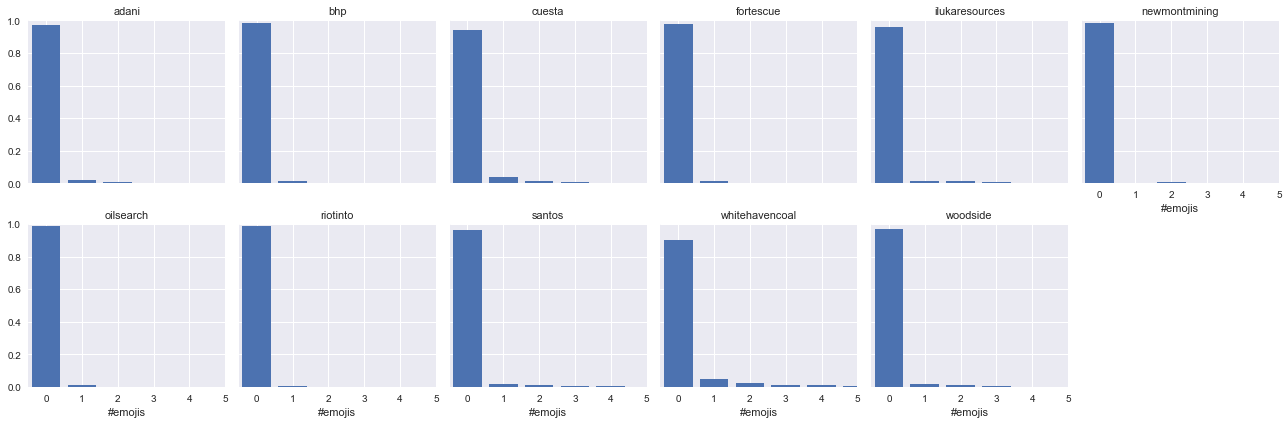

In [65]:
grid = sns.FacetGrid(df[['#emojis', 'company']], col='company', col_wrap=6, ylim=(0, 1), xlim=(-0.5, 5))
grid.map_dataframe(bar_plot, '#emojis').set_titles('{col_name}')

#### Popular emojis

In [66]:
df[['company', 'emojis']][df['emojis'].notnull()].groupby('company')\
    .apply(lambda x: pd.Series([emoji for emojis in x['emojis'] for emoji in emojis])\
                              .value_counts(normalize=True).head())

company          
adani           😡    0.064308
                😂    0.038849
                👏    0.031080
                🤔    0.029261
                💰    0.025789
bhp             ⭐    0.076233
                😂    0.065770
                💰    0.049327
                ❤    0.043348
                👍    0.029895
cuesta          😍    0.136364
                🤣    0.090909
                😄    0.090909
                🥑    0.090909
                😂    0.090909
fortescue       ⭐    0.128571
                👍    0.071429
                💰    0.042857
                😂    0.035714
                👌    0.035714
ilukaresources  ❤    0.114035
                ⭐    0.061404
                ☀    0.061404
                😍    0.052632
                🐳    0.035088
newmontmining   👉    0.222222
                👈    0.222222
                👍    0.222222
                🏼    0.111111
                👌    0.111111
oilsearch       ⭐    0.333333
                😠    0.200000
                📋    0

Angry faced emojis and laughing emojis are likely to be stance against companies.
Emojis are very infrequent, but considering their emotions would be useful.

### Word Frequency

here, not consider tweet-wise splitting.
investigate bag-of-words for each company

**CMU Tweet POS Tagger** is used in this analysis

In [72]:
df_tokpos = df_tokens.groupby('company')\
                     .apply(lambda x: pd.DataFrame.from_records(
                         [(token, pos) for tokens_ea in x['tokens'] for token, pos, p in tokens_ea],
                         columns=['word', 'pos']))\
                     .reset_index().drop('level_1', axis=1)

In [73]:
df_tokpos.isnull().any()

company    False
word       False
pos        False
dtype: bool

#### Total words

In [75]:
token_sizes = df_tokpos.groupby('company').size()
token_sizes

company
adani             2042845
bhp                408130
cuesta               5854
fortescue           71117
ilukaresources      21215
newmontmining        5002
oilsearch           12969
riotinto           177492
santos             284246
whitehavencoal      37627
woodside            85883
dtype: int64

#### Total types

vocabularies of company tweet data

In [79]:
df_tokpos.groupby('company').apply(lambda x: len(x['word'].unique()))

company
adani             149191
bhp                52019
cuesta              2964
fortescue          13973
ilukaresources      5953
newmontmining       1609
oilsearch           3392
riotinto           25772
santos             44073
whitehavencoal      9044
woodside           17901
dtype: int64

In [78]:
# TTR (type/token ratio; a measure of lexical diversity)
df_tokpos.groupby('company').apply(lambda x: len(x['word'].unique())) / token_sizes

company
adani             0.073031
bhp               0.127457
cuesta            0.506320
fortescue         0.196479
ilukaresources    0.280603
newmontmining     0.321671
oilsearch         0.261547
riotinto          0.145201
santos            0.155052
whitehavencoal    0.240359
woodside          0.208435
dtype: float64

Total words decrease 1/4 of RT-included data, but total types shrink in relatively a small scale.

#### Hapax legomena 

words that appear only once (unique words)

In [81]:
df_tokpos.groupby('company').apply(lambda x: x['word'].value_counts().value_counts(normalize=True).loc[1])

company
adani             0.755769
bhp               0.686999
cuesta            0.811404
fortescue         0.657769
ilukaresources    0.662523
newmontmining     0.700435
oilsearch         0.663915
riotinto          0.680545
santos            0.671068
whitehavencoal    0.673485
woodside          0.659181
dtype: float64

Because RTs are removed, the proportion of unique words increased.
Training their embeddings withour RTs would be more difficult; however, I don't know duplicate sentences (RTs) can contribute to the quolity of embeddings.

#### POS tag distributions

##### POS tag description

- N common noun
- O pronoun (personal/WH; not possessive)
- ^ proper noun
- S nominal + possessive
- Z proper noun + possessive
- V verb including copula, auxiliaries
- L nominal + verbal (e.g. i’m), verbal + nominal (let’s)
- M proper noun + verbal
- A adjective
- R adverb
- ! interjection
- D determiner
- P pre- or postposition, or subordinating conjunction
- & coordinating conjunction
- T verb particle
- X existential there, predeterminers
- Y X + verbal
- \# hashtag (indicates topic/category for tweet)
- @ at-mention (indicates a user as a recipient of a tweet)
- ~ discourse marker, indications of continuation across multiple tweets
- U URL or email address
- E emoticon
- $ numeral
- , punctuation
- G other abbreviations, foreign words, possessive endings, symbols, garbage


In [86]:
# example words for POS tags
df_tokpos.groupby('company').get_group('bhp').groupby('pos').apply(lambda x: set(x.sample(10)['word'].values))

pos
!       {yup, Ah, Congrats, Hi, yeah, Dam, heheh, Wow}
#    {#markets, #IoT, #3Novices, #ausbiz, #birdofpr...
$    {$20.3, 3.4%, $14.38, 290, $8.3, 12, 73.5, 41,...
&                                     {AND, and, +, &}
,                                   {., ,, -, ), :, ;}
@    {@DCC_JOBS, @simonahac, @ABCNews, @FT, @greg_n...
A    {Big, Global, New, Most, incredible, biggest, ...
D                                     {The, a, the, A}
E                              {😝, ;), <3, ❤, X, 😜, ️}
G       {$LNG, |, Sout, stor, Citifirst, $, →, >, Btw}
L           {its, What's, I'm, there's, they're, it's}
N    {College, oil, business, respite, div, collaps...
O       {I, he, that, mine, What, We, them, those, we}
P            {+117pts, in, via, since, en, at, of, to}
R    {now, more, Here, b3k, when, else, Clearly, ri...
S    {week’s, year's, yesterday's, company's, chart...
T                                       {out, off, up}
U    {https://t.co/0xj9kOyKsq, https://t.co/bz68hr8...
V    {

In [85]:
# we can define following subsets of POS tags
content_tags   = "A E N R S V Z ^".split(' ')  # R maybe function
function_tags  = "! $ & , D G L O P T X ~".split(' ')
tweetmeta_tags = "# @ U".split(' ')

In [38]:
# check tokenisation/tagging results
for line in df_tokens.sample(20)['tokens'].apply(lambda x: ' '.join([t+'|'+p for t, p, _ in x])).values:
    if '#' in line:
        print('·', line)
# some hashtags used as (proper) nouns might be tagged as (proper) nouns

· Barnaby|^ Joyce|^ still|R hasn't|V sold|V his|D investment|N property|N in|P the|D proposed|N SANTOS|^ coal|N seam|N gas|N field|N in|P NSW|^ -|, Is|V that|O why|R he|O lost|V his|D Agriculture|N portfolio|N ?|, SA|G #MurrayDarling|# Royal|^ Commission|N yet|R to|P report|V -|, is|V that|O why|R he|O lost|V the|D Water|N portfolio|N ?|, #AusPol|# https://t.co/u5B1SVtBLh|U
· Suggesting|V that|O Vinod|^ Adani|^ has|V nothing|N to|P do|V with|P the|D Adani|^ group|N transaction|N is|V "|, absurd|A "|, .|, Now|R new|A court|N case|N into|P scam|N #4Corner|# #StopAdani|#
· Squandering|V $1B|$ for|P to|P aid|V the|D climate-wrecking|N Adani|N coal|N mine|N ?|, These|D community|N members|N say|V yeah|! nar|G !|, #StopAdani|# …|, https://t.co/7J96Jgv5uQ|U
· Outside|A @CommBank|@ in|P #Brisbane|^ to|P say|V stop|V funding|V dirty|A coal|N .|, #StopAdani|# https://t.co/mg5TiAx4km|U
· True|A #TheirABC|^ has|V itself|O been|V generous|A to|P ANTI|^ #Adani|^ stories|N and|& protesters|N ,|, the|

In [74]:
df_tokpos.query('pos != "#"')[df_tokpos.query('pos != "#"')['word'].str.startswith('#')].sample(20)

,company,word,pos
1173664,adani,#Democracy,N
1773108,adani,#Shorten,V
559931,adani,#Adani,N
1676947,adani,#caranua,N
948398,adani,#fossil,A
1170132,adani,#Adani,^
2107522,bhp,#miners,N
1601114,adani,#QLD,^
113264,adani,#Adani,^
305163,adani,#Adani,N


In [82]:
df_posfreq = df_tokpos.groupby('company').apply(lambda x: pd.DataFrame(x['pos'].value_counts(normalize=True).rename('freq')))

In [83]:
df_posfreq.index.names = ['company', 'pos']
df_posfreq.head()

freq
company pos          
adani   N    0.181383
        V    0.142344
        P    0.099154
        ,    0.093872
        ^    0.075132

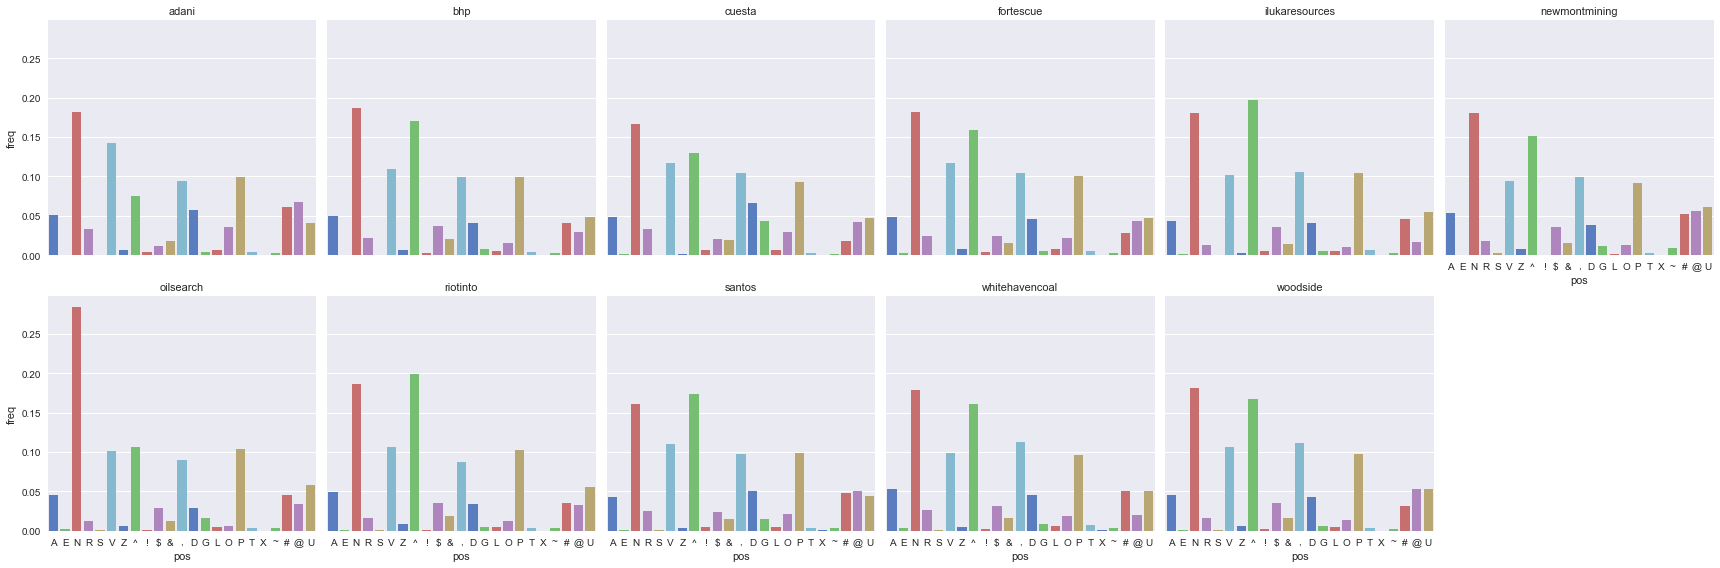

In [87]:
sns.factorplot(x='pos', y='freq', col='company', kind='bar', col_wrap=6, palette='muted', data=df_posfreq.reset_index(),
              order=[*content_tags, *function_tags, *tweetmeta_tags]).set_titles('{col_name}')

#### Content words

In [88]:
df_tokpos.groupby('company').apply(lambda x: len(x[x['pos'].isin(content_tags)])) / token_sizes

company
adani             0.491820
bhp               0.546167
cuesta            0.499488
fortescue         0.541249
ilukaresources    0.542635
newmontmining     0.510996
oilsearch         0.559874
riotinto          0.567304
santos            0.519561
whitehavencoal    0.527945
woodside          0.525063
dtype: float64

In [89]:
df_tokpos.groupby('company').apply(lambda x: x[x['pos'].isin(content_tags)]['word'].value_counts(normalize=True).head())

company                   
adani           Adani         0.047660
                is            0.019177
                coal          0.014698
                #Adani        0.009055
                will          0.008790
bhp             BHP           0.066404
                Billiton      0.017092
                $BHP          0.010363
                is            0.009457
                #BHP          0.005549
cuesta          is            0.013680
                cuesta        0.009918
                are           0.006840
                la            0.006156
                y             0.006156
fortescue       Fortescue     0.065416
                Metals        0.017043
                ore           0.011197
                is            0.011067
                Group         0.008911
ilukaresources  Iluka         0.088777
                Resources     0.013551
                NSW           0.007297
                is            0.006949
                sands         0.00686

In [96]:
# emoticon
df_tokpos.groupby('company').apply(lambda x: len(x[x['pos'] == 'E'])) / token_sizes

company
adani             0.000690
bhp               0.000811
cuesta            0.001708
fortescue         0.002447
ilukaresources    0.002168
newmontmining     0.000800
oilsearch         0.002467
riotinto          0.000608
santos            0.001101
whitehavencoal    0.002923
woodside          0.001386
dtype: float64

In [97]:
df_tokpos.groupby('company').apply(lambda x: x[x['pos'] == 'E']['word'].value_counts(normalize=True).head())
# this includes emojis too

company               
adani           😡         0.119149
                :)        0.075887
                >         0.060993
                😠         0.048936
                😉         0.046809
bhp             >         0.178248
                :)        0.081571
                ❤         0.075529
                😄         0.051360
                ️         0.048338
cuesta          :D        0.100000
                😍😍😍       0.100000
                😁         0.100000
                🎉         0.100000
                ;-)       0.100000
fortescue       >         0.264368
                :)        0.201149
                ;)        0.097701
                :P        0.068966
                :-)       0.040230
ilukaresources  >         0.282609
                ❤         0.086957
                ️         0.043478
                ❤❤        0.043478
                ♡♡♡       0.043478
newmontmining   >         0.500000
                👍👌        0.250000
                DKMSPP    0.2500

they look not so largely changed

#### Function words

In [90]:
df_tokpos.groupby('company').apply(lambda x: len(x[x['pos'].isin(function_tags)])) / token_sizes

company
adani             0.338167
bhp               0.335959
cuesta            0.394090
fortescue         0.339848
ilukaresources    0.339241
newmontmining     0.319472
oilsearch         0.301874
riotinto          0.309991
santos            0.337964
whitehavencoal    0.350174
woodside          0.337389
dtype: float64

#### Twitter specific tags

In [91]:
df_tokpos.groupby('company').apply(lambda x: len(x[x['pos'].isin(tweetmeta_tags)])) / token_sizes

company
adani             0.169994
bhp               0.117874
cuesta            0.106423
fortescue         0.118903
ilukaresources    0.118124
newmontmining     0.169532
oilsearch         0.138253
riotinto          0.122704
santos            0.142461
whitehavencoal    0.121854
woodside          0.137536
dtype: float64

In [92]:
# hashtags
df_tokpos.groupby('company').apply(lambda x: len(x[x['pos'] == '#'])) / token_sizes

company
adani             0.061764
bhp               0.040803
cuesta            0.017936
fortescue         0.028179
ilukaresources    0.046147
newmontmining     0.052379
oilsearch         0.046033
riotinto          0.034841
santos            0.047797
whitehavencoal    0.050947
woodside          0.031694
dtype: float64

In [93]:
df_tokpos.groupby('company').apply(lambda x: x[x['pos'] == '#']['word'].value_counts(normalize=True).head())

company                         
adani           #auspol             0.160905
                #StopAdani          0.151394
                #Adani              0.067137
                #qldpol             0.050090
                #adani              0.037076
bhp             #ausbiz             0.122080
                #auspol             0.045637
                #BHP                0.037651
                #markets            0.034648
                #Australia          0.030685
cuesta          #auspol             0.057143
                #7News              0.019048
                #IntrustSuperCup    0.019048
                #NRL                0.019048
                #socialmedia        0.019048
fortescue       #ausbiz             0.144212
                #auspol             0.040918
                #3Novices           0.037924
                #Business           0.029940
                #ironore            0.029441
ilukaresources  #Iluka              0.048008
                #ausbi

In [94]:
# mentions
df_tokpos.groupby('company').apply(lambda x: len(x[x['pos'] == '@'])) / token_sizes

company
adani             0.066985
bhp               0.029028
cuesta            0.041852
fortescue         0.043731
ilukaresources    0.017252
newmontmining     0.055778
oilsearch         0.034390
riotinto          0.032841
santos            0.050365
whitehavencoal    0.020358
woodside          0.052478
dtype: float64

In [95]:
df_tokpos.groupby('company').apply(lambda x: x[x['pos'] == '@']['word'].value_counts(normalize=True).head())

company                         
adani           @AnnastaciaMP       0.048597
                @stopadani          0.037540
                @billshortenmp      0.027361
                @TurnbullMalcolm    0.026732
                @QLDLabor           0.015522
bhp             @bhpbilliton        0.108720
                @bhp                0.097999
                @FinancialReview    0.029037
                @smh                0.020934
                @ABCNews            0.018486
cuesta          @cqc2t_             0.102041
                @BoltzmannMick      0.061224
                @transhumanismAU    0.057143
                @Science_Academy    0.057143
                @thepmo             0.057143
fortescue       @fortescue          0.255627
                @FortescueNews      0.190354
                @FinancialReview    0.019293
                @smh                0.015113
                @TurnbullMalcolm    0.011576
ilukaresources  @IlukaResources     0.251366
                @iluka

#### Out of vocabulary words

In [112]:
# The vocaburaly of GloVe word embeddings (6B, Wikipedia + GigaWord)
with open('common_words/word_list-wikigiga.txt') as f:
    word_list_wiki = [line.strip() for line in f]

In [113]:
# exclude tweetmeta_tags
# just make tokens lowercase for the purpose of normalisation
df_tokpos.groupby('company').apply(lambda x: len(set(x[x['pos'].isin([*content_tags, *function_tags])]['word'].str.lower().unique()) - set(word_list_wiki))) / token_sizes

company
adani             0.008276
bhp               0.020266
cuesta            0.057397
fortescue         0.024945
ilukaresources    0.033797
newmontmining     0.032387
oilsearch         0.031999
riotinto          0.015899
santos            0.022871
whitehavencoal    0.032875
woodside          0.025337
dtype: float64

they are around 3% of the vocabulary, which means not so large

In [114]:
# example OOV words
def oov_freq(subdf, word_list, rm_hash=False):
    alltok = set(subdf[subdf['pos'].isin([*content_tags, *function_tags])]['word'].str.lower().unique())
    oovtok = alltok - set(word_list)
    if not rm_hash:
        return subdf['word'].value_counts(normalize=True).reindex(oovtok)
    else:
        return subdf[~subdf['word'].str.startswith('#')]['word'].value_counts(normalize=True).reindex(oovtok)

df_tokpos.groupby('company').apply(lambda x: oov_freq(x, word_list_wiki, rm_hash=True).sort_values(ascending=False).head())

company                   
adani           don't         0.001167
                ..            0.001111
                it's          0.000791
                won't         0.000727
                doesn't       0.000661
bhp             ..            0.000802
                it's          0.000327
                don't         0.000319
                →             0.000236
                won't         0.000228
cuesta          ..            0.001748
                it's          0.000699
                ولا           0.000699
                we've         0.000524
                اللهم         0.000524
fortescue       it's          0.000642
                ..            0.000569
                don't         0.000481
                can't         0.000365
                •             0.000292
ilukaresources  ..            0.000850
                65x180cm      0.000500
                •             0.000450
                $224m         0.000400
                $375m         0.00040

some sort of normalisation might solve the mismatch

In [115]:
# The vocaburaly of GloVe word embeddings (27B, Twitter)
with open('common_words/word_list-twitter.txt') as f:
    word_list_twi = [line.strip() for line in f]

In [116]:
# exclude tweetmeta_tags
df_tokpos.groupby('company').apply(lambda x: len(set(x[x['pos'].isin([*content_tags, *function_tags])]['word'].str.lower().unique()) - set(word_list_twi))) / token_sizes

company
adani             0.008742
bhp               0.023105
cuesta            0.048343
fortescue         0.029894
ilukaresources    0.042046
newmontmining     0.037585
oilsearch         0.038708
riotinto          0.018575
santos            0.021035
whitehavencoal    0.039201
woodside          0.033546
dtype: float64

they are around 3% of the vocabulary, which means not so large

In [117]:
# example OOV words
df_tokpos.groupby('company').apply(lambda x: oov_freq(x, word_list_twi, rm_hash=True).sort_values(ascending=False).head())

company                    
adani           ...            0.003380
                don't          0.001167
                ..             0.001111
                coalmine       0.001076
                it's           0.000791
bhp             ...            0.004476
                200            0.001025
                ..             0.000802
                16             0.000657
                4              0.000522
cuesta          ...            0.003671
                2018           0.002098
                ..             0.001748
                7              0.000874
                1st            0.000699
fortescue       ...            0.005179
                it's           0.000642
                ..             0.000569
                :)             0.000511
                don't          0.000481
ilukaresources  ...            0.005448
                2016           0.001150
                2017           0.001100
                33             0.000950
            

---
End of the analysis